In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
Epoch [1/80], Step [100/500] Loss: 1.6664
Epoch [1/80], Step [200/500] Loss: 1.5435
Epoch [1/80], Step [300/500] Loss: 1.4617
Epoch [1/80], Step [400/500] Loss: 1.4188
Epoch [1/80], Step [500/500] Loss: 1.1535
Epoch [2/80], Step [100/500] Loss: 1.1392
Epoch [2/80], Step [200/500] Loss: 1.1811
Epoch [2/80], Step [300/500] Loss: 1.2046
Epoch [2/80], Step [400/500] Loss: 1.2544
Epoch [2/80], Step [500/500] Loss: 1.0086
Epoch [3/80], Step [100/500] Loss: 0.9385
Epoch [3/80], Step [200/500] Loss: 0.8806
Epoch [3/80], Step [300/500] Loss: 1.1734
Epoch [3/80], Step [400/500] Loss: 0.9398
Epoch [3/80], Step [500/500] Loss: 1.0343
Epoch [4/80], Step [100/500] Loss: 0.8831
Epoch [4/80], Step [200/500] Loss: 0.8751
Epoch [4/80], Step [300/500] Loss: 1.0369
Epoch [4/80], Step [400/500] Loss: 0.8831
Epoch [4/80], Step [500/500] Loss: 0.8778
Epoch [5/80], Step [100/500] Loss: 1.0447
Epoch [5/80], Step [200/500] Loss: 0.9573
Epoch [5/80], St

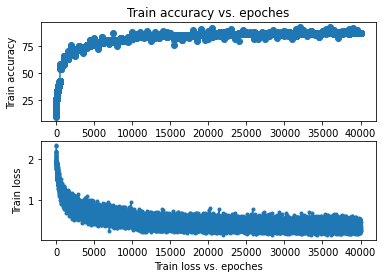

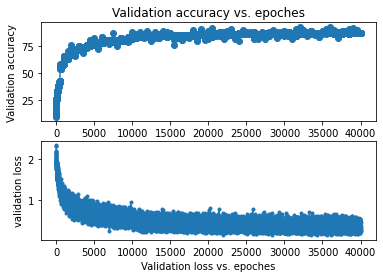

<Figure size 432x288 with 0 Axes>

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# vis = visdom.Visdom()
# vis.server.start()

train_loss_list = []
train_accuracy_list = []

validation_loss_list = []
validation_accuracy_list = []




# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0]//2)
        self.layer2 = self.make_layer(block, 32, layers[1]//2, 2)
        self.layer3 = self.make_layer(block, 64, layers[2]//2, 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
    


    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    total = 0
    correct  = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # vis.line(X=np.array([epoch]), Y=np.array([loss]), win='loss', update='append')

        train_loss_list.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        train_accuracy_list.append(100 * correct / total)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        validation_loss_list.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        validation_accuracy_list.append(100 * correct / total)

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')
x1 = range(0, 40000)
x2 = range(0, 40000)
y1 = train_accuracy_list
y2 = train_loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.show()
plt.savefig("train_accuracy_loss.jpg")

x3 = range(0, 40000)
x4 = range(0, 40000)
y3 = train_accuracy_list
y4 = train_loss_list
plt.subplot(2, 1, 1)
plt.plot(x3, y3, 'o-')
plt.title('Validation accuracy vs. epoches')
plt.ylabel('Validation accuracy')
plt.subplot(2, 1, 2)
plt.plot(x4, y4, '.-')
plt.xlabel('Validation loss vs. epoches')
plt.ylabel('validation loss')
plt.show()
plt.savefig("validation_accuracy_loss.jpg")


In [3]:

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
model.load_state_dict(torch.load("resnet.ckpt"))
model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(

In [4]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


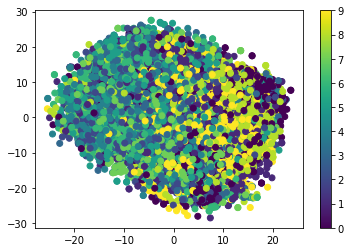

In [5]:
model.load_state_dict(torch.load("resnet.ckpt"))
model.eval()

# Extract features of the layer before the classifier
features = []
labels = []
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        outputs = model.conv(images)
        features.append(outputs.reshape(outputs.size(0), -1).cpu().numpy())
        labels.append(targets.numpy())

# Concatenate features and labels
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Fit tSNE
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features)

# Plot tSNE
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap="viridis")
plt.colorbar()
plt.show()